In [2]:
# Update following paths (including the one in load_data) to your local paths
# Synch your data with the remote server
# Update the csv file whit all information on runs

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize as op
from scipy.stats import linregress
from scipy.optimize import curve_fit
import plotly.express as px
import statsmodels.api as sm
import numpy as np
from scipy.optimize import curve_fit
import os
from IPython.display import display, HTML
import re
from docx import Document
from docx.shared import Inches
from docx.shared import RGBColor
from io import BytesIO
from IPython.display import clear_output
import time
dir_path = r"C:\Users\louis\OneDrive\Bureau\Stage Tokyo\data_Spring8\runs900410to906551"
folder = r"C:\Users\louis\OneDrive\Bureau\Stage Tokyo\data_Spring8"
folder_path_runs = 'C:/Users/louis/OneDrive/Bureau/Stage Tokyo/data_Spring8/docs_runs/'

In [3]:
# Load data from a specific run
def load_current_Scan(runstart, runend):
    df0 = pd.read_csv(dir_path+'/run'+str(runstart)+'.csv')
    SXMOKE_On = []
    SXMOKE_Off = []
    SXFUN_On = []
    SXFUN_Off = []
    for ii in range(runstart, runend + 1):
        df0 = pd.read_csv(f'/Users/louis/OneDrive/Bureau/Stage Tokyo/data_Spring8/runs900410to906551/run{ii}.csv')
    # 清理列名前后的空格
        df0.columns = df0.columns.str.strip()
        df0['On'] = df0['On'].fillna(0)
        for kk in range(len(df0)):
            I_raw = df0['I_raw'].iloc[kk]
            I_norm = df0['I_norm'].iloc[kk]
            I0_GM2 = df0['I0(GM2)'].iloc[kk]
            On_val = df0['On'].iloc[kk]
            if -1 < I_raw < 0.4 and I0_GM2 > -1:
                if On_val > 0.1:
                    df_MOKE_Off = I_raw
                    df_fun_Off = I0_GM2
                    SXMOKE_Off.append(df_MOKE_Off)
                    SXFUN_Off.append(df_fun_Off)
                elif On_val <= 0.1:
                    df_MOKE_On = I_raw
                    df_fun_On = I0_GM2
                    SXMOKE_On.append(df_MOKE_On)
                    SXFUN_On.append(df_fun_On)
    return np.array(SXMOKE_On), np.array(SXMOKE_Off), np.array(SXFUN_On),np.array(SXFUN_Off)  

# Making sure the arrays have the same length
def match_array_lengths_and_apply_mask(arr1, arr2, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    len1, len2 = len(arr1), len(arr2)
    if len1 == len2:
        return arr1, arr2
    elif len1 > len2:
        remove_indices = np.random.choice(len1, len1 - len2, replace=False)
        keep_mask = np.ones(len1, dtype=bool)
        keep_mask[remove_indices] = False
        return arr1[keep_mask], arr2, keep_mask
    else:
        remove_indices = np.random.choice(len2, len2 - len1, replace=False)
        keep_mask = np.ones(len2, dtype=bool)
        keep_mask[remove_indices] = False
        return arr1, arr2[keep_mask], keep_mask 


Average of the 61 subsets' relative differences: 0.007696
Linear regression: slope = 0.0002026, intercept = 0.001415, r_value = 0.121, p_value = 0.3527, std_err = 0.0002163


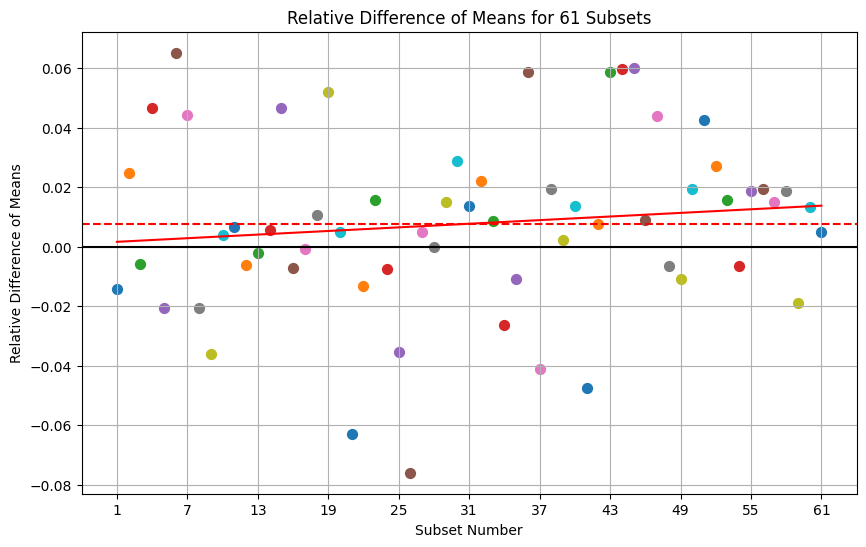

In [4]:
# Plot data of a single run
run_id =  905720
SXMOKE_On, SXMOKE_Off, SXFUN_On, SXFUN_Off = load_current_Scan(run_id, run_id)
mask_on = np.isfinite(SXFUN_On) & np.isfinite(SXMOKE_On)
mask_off = np.isfinite(SXFUN_Off) & np.isfinite(SXMOKE_Off)
y_on = SXMOKE_On[mask_on]
y_off = SXMOKE_Off[mask_off]
'''
plt.figure(figsize=(10, 6))
plt.plot(SXFUN_On, y_on, 'o', label='On', markersize=3)
plt.plot(SXFUN_Off, y_off, 'o', label='Off', markersize=3)
plt.show()
print(len(y_on), len(y_off))
'''
SXMOKE_On_corr, SXMOKE_Off_corr, mask = match_array_lengths_and_apply_mask(y_on, y_off, random_seed=45)
SXFUN_On_corr = SXFUN_On[mask] if len(y_on) > len(y_off) else SXFUN_On
SXFUN_Off_corr = SXFUN_Off[mask] if len(y_off) > len(y_on) else SXFUN_Off

n_subsets = len(y_on)//30
min_len = min(len(y_on), len(y_off))
subset_size = min_len // n_subsets
rel_diffs = []
subset_indices = []
plt.figure(figsize=(10, 6))
for i in range(n_subsets):
    start = i * subset_size
    end = (i + 1) * subset_size if i < n_subsets - 1 else min_len
    on_chunk = SXMOKE_On_corr[start:end]
    off_chunk = SXMOKE_Off_corr[start:end]
    mean_on = np.mean(on_chunk)
    mean_off = np.mean(off_chunk)
    rel_diff = (mean_on - mean_off) / mean_off if mean_off != 0 else np.nan
    rel_diffs.append(rel_diff)
    subset_indices.append(i + 1)
    print(f"Subset {i+1}: Relative Difference of means = {rel_diff:.6f}")
    clear_output(wait=True)
    plt.scatter(i+1, rel_diff, label=f'Subset {i+1}', s=50)
# Average 
avg_rel_diff = np.nanmean(rel_diffs)
print(f"Average of the {n_subsets} subsets' relative differences: {avg_rel_diff:.6f}")
# Linear regression
subset_indices = np.array(subset_indices)
rel_diffs = np.array(rel_diffs)
slope, intercept, r_value, p_value, std_err = linregress(subset_indices, rel_diffs)
fit_line = slope * subset_indices + intercept
plt.plot(subset_indices, fit_line, color='red', label=f'Linear fit (slope={slope:.4g})')
print(f"Linear regression: slope = {slope:.4g}, intercept = {intercept:.4g}, r_value = {r_value:.4g}, p_value = {p_value:.4g}, std_err = {std_err:.4g}")
plt.axhline(y=avg_rel_diff, color='red', linestyle='--', label='Average Relative Difference')
plt.axhline(y=0, color='black', linestyle='-')
plt.grid()
plt.xlabel('Subset Number')
plt.ylabel('Relative Difference of Means')
plt.title('Relative Difference of Means for {} Subsets'.format(n_subsets))
xticks = np.arange(1, n_subsets + 1)
step = max(1, int(len(xticks) * 0.1))
plt.xticks(xticks[::step])
#plt.legend()
plt.show()

Using run :  904704
Using run :  904705
Using run :  904706
Using run :  904707
Using run :  904708
Using run :  904709
Using run :  904710
Using run :  904711
Using run :  904712
Using run :  904713
Using run :  904715
Using run :  904716
Using run :  904717
Using run :  904718
Using run :  904719
Using run :  904720
Using run :  904721
Using run :  904722
Using run :  904723
Using run :  904724
Using run :  904725
Using run :  904726
Using run :  904727
Using run :  904728
Using run :  904729
Using run :  904730
Using run :  904731
Using run :  904732
Using run :  904733
Using run :  904734
Using run :  904735
Using run :  904736
Using run :  904737


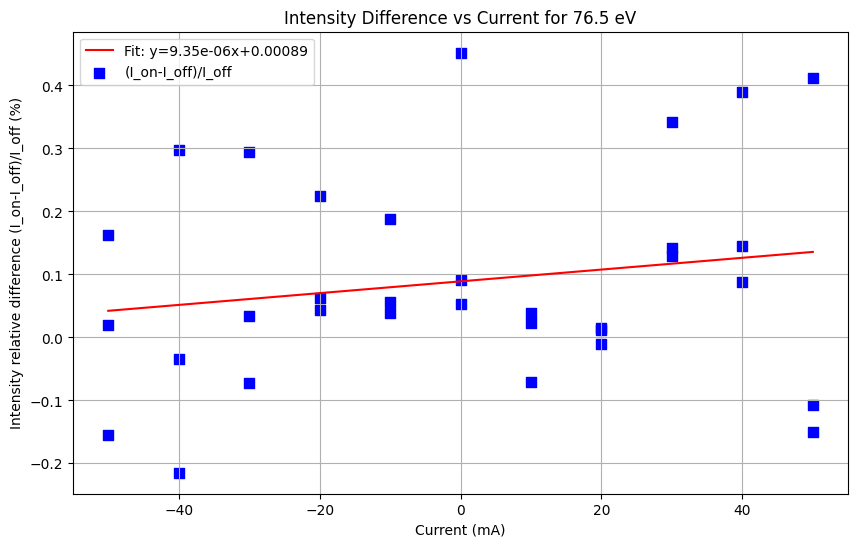

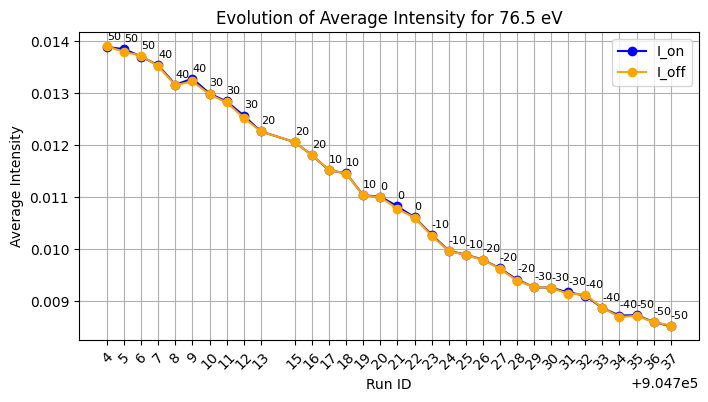

In [ ]:
# Analyzing data for 1 specific photon energy
eV = 76.5 # photon energy
run_id_first = 904704 # first run for this eV
run_id_last = 904737 # last run for this eV
if run_id_first > run_id_last:
    raise ValueError("run_id_first should be lower than run_id_last")
df = pd.read_csv(folder+'\\202505_orbital_MOKE - 工作表1.csv')
df.columns = df.columns.str.strip()
# Filter rows that start with 'Current measurement#'
mask = df[df.columns[0]].astype(str).str.startswith('Current measurement#')
df_current_measurements = df[mask]
start_run_arr = df_current_measurements['start run#'].values.tolist()
end_run_arr = df_current_measurements['end run#'].values.tolist()
start_run_arr_int = [int(x) for x in start_run_arr]
end_run_arr_int = [int(x) for x in end_run_arr]
# (2nd identique filter for verification) Only selecting if run start and end are both in the data meaning only 1 run for 1 line
run_id_list = np.arange(run_id_first, run_id_last+1).tolist()
run_id_list_real = [x for x in run_id_list if x in start_run_arr_int and x in end_run_arr_int]
if run_id_list_real == []:
    raise ValueError("No current measurement found in the specified range.")
Current_list = []
I_on_list = []
I_off_list = []
I_list = []
for run_id in run_id_list_real:
    run_name = '     '+str(run_id)
    print('Using run : ', run_id)
    clear_output(wait=True)
    scan_value = df_current_measurements.loc[df_current_measurements['start run#'] == run_name, 'Scan'].values
    photon_energy_value = df_current_measurements.loc[df_current_measurements['start run#'] == run_name, 'Photon Energy'].values
    run_value = run_id
    current_value = df_current_measurements.loc[df_current_measurements['start run#'] == run_name, 'Current (mA)'].values
    Gain_value = df_current_measurements.loc[df_current_measurements['start run#'] == run_name, 'Gain settting'].values
    MCP_value = df_current_measurements.loc[df_current_measurements['start run#'] == run_name, 'MCP Voltage'].values
    if photon_energy_value != ' '+str(eV)+'eV         ':
        if photon_energy_value != ' '+str(eV)+'eV       ':
            print("Photon energy of this run is not {} eV. Skipping this run.".format(eV))
            continue
    SXMOKE_On, SXMOKE_Off, SXFUN_On, SXFUN_Off = load_current_Scan(run_id, run_id)
    # Remove NaN/inf
    mask_on = np.isfinite(SXFUN_On) & np.isfinite(SXMOKE_On)
    mask_off = np.isfinite(SXFUN_Off) & np.isfinite(SXMOKE_Off)
    y_on = SXMOKE_On[mask_on]
    y_off = SXMOKE_Off[mask_off]
    avg_y_on = np.mean(y_on)
    avg_y_off = np.mean(y_off)
    current_value_float = float(current_value[0].replace('mA', ''))
    I_on_list.append(avg_y_on)
    I_off_list.append(avg_y_off)
    if avg_y_off != 0:
        Current_list.append(current_value_float)
        I_list_value = (avg_y_on - avg_y_off) / avg_y_off
        I_list.append(I_list_value)
    else:
        print("Error: I_off is zero, cannot divide by zero.")
plt.figure(figsize=(10, 6))
slope, intercept, r_value, p_value, std_err = linregress(Current_list, I_list)
fit_x = np.array(Current_list)
fit_y = slope * fit_x + intercept
plt.plot(fit_x, np.array(fit_y)*100, color='red', label=f'Fit: y={slope:.3g}x+{intercept:.3g}')
plt.scatter(Current_list, np.array(I_list)*100, color='blue',marker='s', s=50, label='(I_on-I_off)/I_off')
#plt.plot(Current_list, I_fit, color='red')
plt.title('Intensity Difference vs Current for {} eV'.format(eV))
plt.xlabel('Current (mA)')
plt.ylabel('Intensity relative difference (I_on-I_off)/I_off (%)')
plt.legend()
plt.grid()
plt.show()
# Analyzing evolution of average intensity
plt.figure(figsize=(8, 4))
plt.plot(run_id_list_real, I_on_list, label='I_on', marker='o', color='blue')
plt.plot(run_id_list_real, I_off_list, label='I_off', marker='o', color='orange')
plt.xlabel('Run ID')
plt.xticks(run_id_list_real, rotation=45)
plt.ylabel('Average Intensity')
plt.title('Evolution of Average Intensity for {} eV'.format(eV))
plt.legend()
plt.grid()
print("Number of runs analyzed: ", len(run_id_list_real))
plt.tight_layout()
for x, y, current in zip(run_id_list_real, I_on_list, Current_list):
    plt.text(x, y+0.0001, f'{current:.0f}', fontsize=8, ha='left', va='bottom', color='black')
plt.show()

Explanation for the decrease in average MCP intensity (see below) can be sample heating and thermal expansion due to applied current or XFEL beam on the sample. The local temperature rise can lead to : 
- Thermal expansion, changing the optical path and incidence angle
- Changes in reflectivity and absorption coefficients
- Orbital population redistribution, even under current-OFF condition? doubt it.
Heating can cause a quasi-linear rise in temperature over time if cooling is weak → causing linear degradation of optical reflectivity.
- Monitor the sample holder temperature

Beam Damage or Sample Degradation :  Most probable due to resistance drop
- Surface carbonization or oxidation
- Photo-induced desorption
- Intermixing or changes in the CuO or FeCo layer structure
- Damage accumulates quasi-linearly with pulse count, especially if the damage cross-section is small but cumulative.
- Compare reflectivity at the beginning and end of the experiment with the current off.
- Break bonds + Induce oxygen vacancies in CuO
CuO becomes more conductive

MCP change : 
- Charge depletion on the microchannel plates
- Slow voltage instability
- MCPs often exhibit a slow linear gain drop under constant load or during long exposures, especially if not pulsed properly.
- Normalize MCP signal with a beam monitor or by inserting a reference reflection 

XFEL Beam intensity change : 
- Many FELs have quasi-linear flux drifts over long scans due to slow tuning changes or beam loading.
- Use incident intensity monitors to correlate FEL pulse energy with detected signal.

Used 104 runs


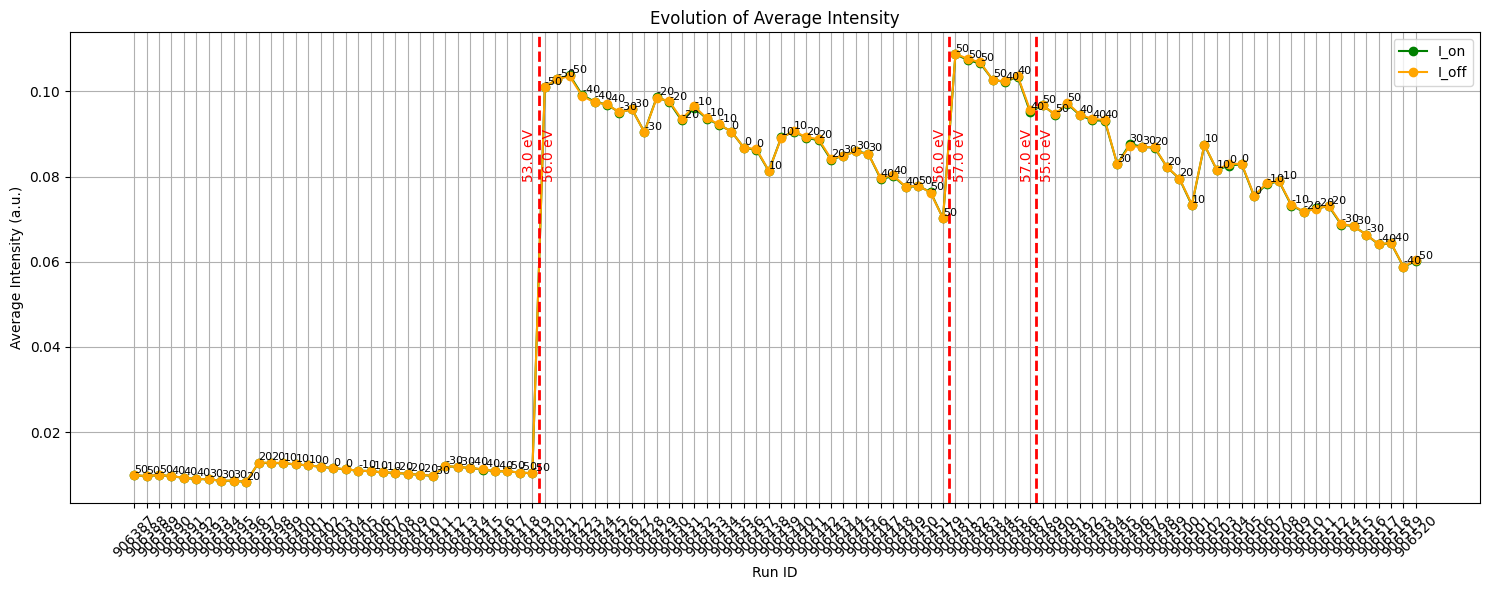

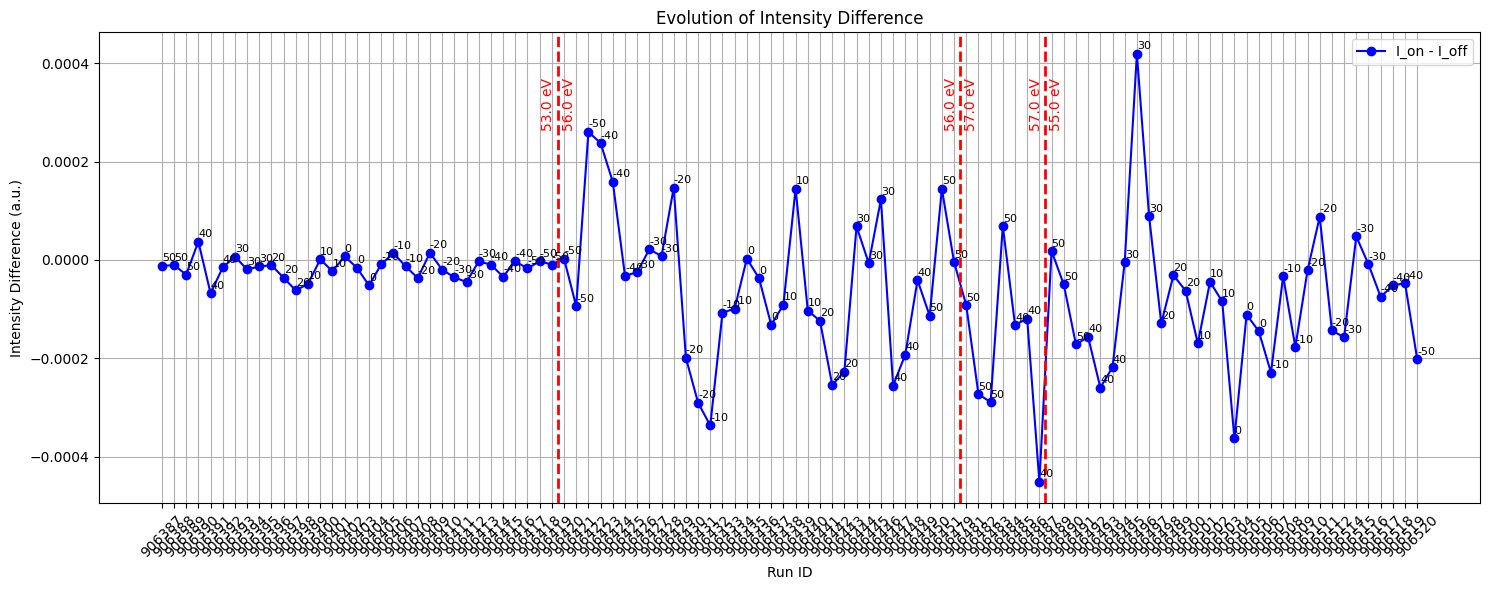

In [14]:
# I want to do the same but for multiple photon energies 
# Need to know if the sample has been moved or not
run_id_first = 906380 # first run for this eV
run_id_last = 906520 # last run for this eV
if run_id_first > run_id_last:
    raise ValueError("run_id_first should be lower than run_id_last")
df = pd.read_csv(folder+'\\202505_orbital_MOKE - 工作表1.csv')
df.columns = df.columns.str.strip()
# Filter rows that start with 'Current measurement#'
mask = df[df.columns[0]].astype(str).str.startswith('Current measurement#')
df_current_measurements = df[mask]
start_run_arr = df_current_measurements['start run#'].values.tolist()
end_run_arr = df_current_measurements['end run#'].values.tolist()
start_run_arr_int = [int(x) for x in start_run_arr]
end_run_arr_int = [int(x) for x in end_run_arr]
run_id_list = np.arange(run_id_first, run_id_last+1).tolist()
run_id_list_real = [x for x in run_id_list if x in start_run_arr_int and x in end_run_arr_int]
if run_id_list_real == []:
    raise ValueError("No current measurement found in the specified range.")
Current_list = []
I_on_list = []
I_off_list = []
I_list = []
E_photon_list = []
Used_run = []
for i,run_id in enumerate(run_id_list_real):
    run_name = '     '+str(run_id)
    scan_value = df_current_measurements.loc[df_current_measurements['start run#'] == run_name, 'Scan'].values
    photon_energy_value = df_current_measurements.loc[df_current_measurements['start run#'] == run_name, 'Photon Energy'].values
    run_value = run_id
    E_photon_list.append(float(photon_energy_value[0].replace('eV         ', '').replace('eV       ', '')))
    Used_run.append(run_id)
    clear_output(wait=True)
    print('Using run : {}     Photon Energy : {} eV     Total : {}'.format(run_id,E_photon_list[-1],len(Used_run)))
    current_value = df_current_measurements.loc[df_current_measurements['start run#'] == run_name, 'Current (mA)'].values
    Gain_value = df_current_measurements.loc[df_current_measurements['start run#'] == run_name, 'Gain settting'].values
    MCP_value = df_current_measurements.loc[df_current_measurements['start run#'] == run_name, 'MCP Voltage'].values
    SXMOKE_On, SXMOKE_Off, SXFUN_On, SXFUN_Off = load_current_Scan(run_id, run_id)
    # Remove NaN/inf
    mask_on = np.isfinite(SXFUN_On) & np.isfinite(SXMOKE_On)
    mask_off = np.isfinite(SXFUN_Off) & np.isfinite(SXMOKE_Off)
    y_on = SXMOKE_On[mask_on]
    y_off = SXMOKE_Off[mask_off]
    avg_y_on = np.mean(y_on)
    avg_y_off = np.mean(y_off)
    current_value_float = float(current_value[0].replace('mA', ''))
    I_on_list.append(avg_y_on)
    I_off_list.append(avg_y_off)
    if avg_y_off != 0:
        Current_list.append(current_value_float)
        I_list_value = (avg_y_on - avg_y_off) / avg_y_off
        I_list.append(I_list_value)
    else:
        raise ValueError("Error: I_off is zero, cannot divide by zero.")
    print('I_on : ',avg_y_on)
clear_output(wait=True)
print("Used {} runs".format(len(Used_run)))
plt.figure(figsize=(15, 6))
x_idx = np.arange(len(run_id_list_real))
plt.plot(x_idx, I_on_list, label='I_on', marker='o', color='green')
plt.plot(x_idx, I_off_list, label='I_off', marker='o', color='orange')
plt.xlabel('Run ID')
plt.xticks(x_idx, [str(r) for r in run_id_list_real], rotation=45)
plt.ylabel('Average Intensity (a.u.)')
plt.title('Evolution of Average Intensity')
plt.legend()
plt.grid()
for x, y, current in zip(x_idx, I_on_list, Current_list):
    plt.text(x, y+0.0001, f'{current:.0f}', fontsize=8, ha='left', va='bottom', color='black')
E_photon_arr = np.array(E_photon_list)
change_indices = np.where(E_photon_arr[:-1] != E_photon_arr[1:])[0] + 1  # +1 to get the index after the change
for idx in change_indices:
    x_pos = idx - 0.5 
    plt.axvline(x=x_pos, color='red', linestyle='--', linewidth=2)
    plt.text(x_pos - 0.2, plt.ylim()[1]*0.80, f"{E_photon_arr[idx-1]:.1f} eV", color='red', ha='right', va='top', fontsize=10, rotation=90)
    plt.text(x_pos + 0.3, plt.ylim()[1]*0.80, f"{E_photon_arr[idx]:.1f} eV", color='red', ha='left', va='top', fontsize=10, rotation=90)
plt.tight_layout()
img_path = 'images/average_intensity_'+str(run_id_first)+'_to_'+str(run_id_last)+'.png'
if os.path.exists(img_path):
    raise FileExistsError(f"Image file {img_path} already exists. Please remove it before saving.")
plt.savefig(img_path, dpi=300)
plt.show()
# Similar than above but for the difference of intensity
plt.figure(figsize=(15, 6))
x_idx = np.arange(len(run_id_list_real))
I_diff_list = np.array(I_on_list) - np.array(I_off_list)
plt.plot(x_idx, I_diff_list, label='I_on - I_off', marker='o', color='blue')
plt.xlabel('Run ID')
plt.xticks(x_idx, [str(r) for r in run_id_list_real], rotation=45)
plt.ylabel('Intensity Difference (a.u.)')
plt.title('Evolution of Intensity Difference')
plt.legend()
plt.grid()
for x, y, current in zip(x_idx, I_diff_list, Current_list):
    plt.text(x, y+0.000005, f'{current:.0f}', fontsize=8, ha='left', va='bottom', color='black')
E_photon_arr = np.array(E_photon_list)
change_indices = np.where(E_photon_arr[:-1] != E_photon_arr[1:])[0] + 1 
for idx in change_indices:
    x_pos = idx - 0.5 
    plt.axvline(x=x_pos, color='red', linestyle='--', linewidth=2)
    plt.text(x_pos - 0.2, plt.ylim()[1]*0.80, f"{E_photon_arr[idx-1]:.1f} eV", color='red', ha='right', va='top', fontsize=10, rotation=90)
    plt.text(x_pos + 0.3, plt.ylim()[1]*0.80, f"{E_photon_arr[idx]:.1f} eV", color='red', ha='left', va='top', fontsize=10, rotation=90)
plt.tight_layout()
img_path = 'images/average_intensity_difference_'+str(run_id_first)+'_to_'+str(run_id_last)+'.png'
if os.path.exists(img_path):
    raise FileExistsError(f"Image file {img_path} already exists. Please remove it before saving.")
plt.savefig(img_path, dpi=300)
plt.show()

For the runs 906387, 906522 the increase in energy is due to the change of an Al filter. 
I should look more into it by comparing the rate at wich the material is being damaged with the different filters. 